In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import datetime as dt
import math
from sklearn.preprocessing import StandardScaler
from matplotlib.pylab import rcParams
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('newresultado_join.csv', index_col='Date')
df = df.drop(labels=['Volume', 'polarity', 'subjectivity'], axis=1)
df

,High,Low,Open,Close,Adj Close
Date,,,,,
2017-01-02,60227.0,59371.0,60227.0,59589.0,59589.0
2017-01-03,61815.0,59631.0,59631.0,61814.0,61814.0
2017-01-04,61940.0,61302.0,61811.0,61589.0,61589.0
2017-01-05,62409.0,61594.0,61594.0,62071.0,62071.0
2017-01-06,62072.0,61396.0,62072.0,61665.0,61665.0
...,...,...,...,...,...
2020-12-22,116903.0,115648.0,115825.0,116348.0,116348.0
2020-12-23,118311.0,116636.0,116636.0,117857.0,117857.0
2020-12-28,119213.0,117805.0,117806.0,119051.0,119051.0


In [4]:
X = np.asarray(df.iloc[:738, :-1])
y = np.asarray(df.iloc[:738, -1])

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

In [7]:
X_scaled.shape

(738, 4)

In [8]:
X_train = []
y_train = []
for i in range(20, len(X)):
    X_train.append(X_scaled[i-20:i,:])
    y_train.append(y_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))

In [10]:
regressor = Sequential()

In [11]:
regressor.add(LSTM(units = 120, return_sequences = True, input_shape = (X_train.shape[1], 4)))
regressor.add(Dropout(0.2))

In [12]:
regressor.add(LSTM(units = 120, return_sequences = True))
regressor.add(Dropout(0.2))

In [13]:
regressor.add(LSTM(units = 120, return_sequences = True))
regressor.add(Dropout(0.2))

In [14]:
regressor.add(LSTM(units = 120))
regressor.add(Dropout(0.2))

In [15]:
regressor.add(Dense(units = 1))

In [16]:
regressor.compile(optimizer = 'adam', loss = 'mse')

In [17]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
23/23 [==============================] - 6s 37ms/step - loss: 0.1560
Epoch 2/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0597
Epoch 3/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0469
Epoch 4/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0401
Epoch 5/100
23/23 [==============================] - 1s 40ms/step - loss: 0.0378
Epoch 6/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0317
Epoch 7/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0310
Epoch 8/100
23/23 [==============================] - 1s 39ms/step - loss: 0.0331
Epoch 9/100
23/23 [==============================] - 1s 39ms/step - loss: 0.0358
Epoch 10/100
23/23 [==============================] - 1s 39ms/step - loss: 0.0363
Epoch 11/100
23/23 [==============================] - 1s 56ms/step - loss: 0.0310
Epoch 12/100
23/23 [==============================] - 1s 42ms/step - loss: 0.0263
Epoch 13/100
23/23 [=====

In [18]:
dataset_test = pd.read_csv('newresultado_test.csv', index_col='Date')
dataset_test = dataset_test.drop(labels=['Volume', 'polarity', 'subjectivity'], axis=1)
real_stock_price = dataset_test.iloc[:, 4:5].values

In [19]:
dataset_total = pd.concat((df, dataset_test), axis = 0)
inputs = dataset_total.iloc[len(dataset_total) - len(dataset_test) - 20:, :-1]
inputs = scaler.transform(inputs)

In [20]:
X_test = []
for i in range(20, len(inputs)):
    X_test.append(inputs[i-20:i, :])
X_test = np.array(X_test)

In [21]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))
predicted_stock_price = regressor.predict(X_test)

In [22]:
y_test_scaled = y_scaler.transform(real_stock_price)
mse = mean_squared_error(y_test_scaled, predicted_stock_price)
mse

0.03027529804357264

In [23]:
predicted_stock_price = y_scaler.inverse_transform(predicted_stock_price)

In [24]:
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
r2 = r2_score(real_stock_price, predicted_stock_price)
mape = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)
mse = mean_squared_error(real_stock_price, predicted_stock_price, squared=False)

print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)
print('MAPE: %.3f' % mape)
print('RMSE: %.3f' % mse)

MAE: 1656.421
R2: 0.966
MAPE: 0.018
RMSE: 2502.872


In [38]:
data_dis = pd.DataFrame(dataset_test, columns=['Adj Close'])
data_dis.dropna(inplace=True)

In [39]:
yhat_dis = pd.DataFrame(predicted_stock_price, index=dataset_test.index.copy())

In [41]:
yhat_dis.index = pd.to_datetime(yhat_dis.index)
data_dis.index = pd.to_datetime(data_dis.index)

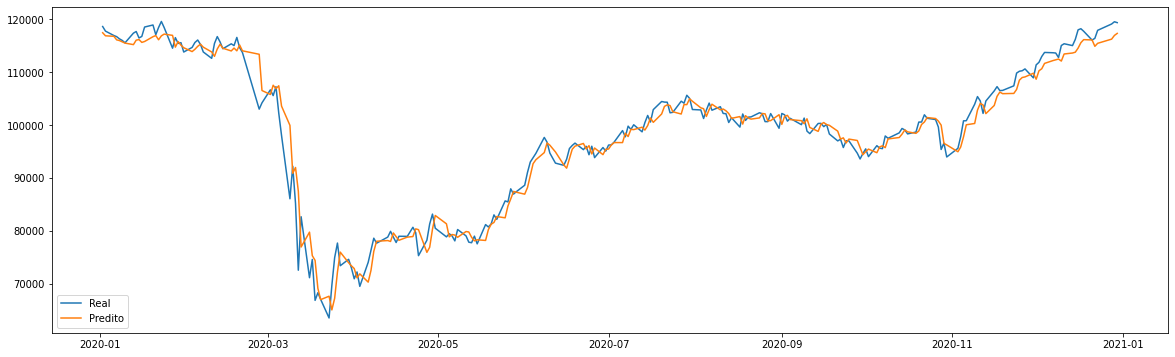

In [42]:
rcParams['figure.figsize'] = 20, 6
plt.pyplot.plot(data_dis, label='Real')
plt.pyplot.plot(yhat_dis, label='Predito')
plt.pyplot.legend()
plt.pyplot.show()